In [44]:
import numpy as np
import pandas as pd
from scipy.stats import iqr
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import confusion_matrix
from sklearn import tree, metrics
import sklearn.metrics as metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.inspection import permutation_importance
from xgboost import XGBClassifier

In [9]:
df = pd.read_csv('ks-projects-201801.csv')

df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [11]:
for col in df:
    print(df[col].unique())

[1000002330 1000003930 1000004038 ...  999986353  999987933  999988282]
['The Songs of Adelaide & Abullah'
 'Greeting From Earth: ZGAC Arts Capsule For ET' 'Where is Hank?' ...
 'Walls of Remedy- New lesbian Romantic Comedy feature unlike any other!!'
 'BioDefense Education Kit' 'Nou Renmen Ayiti!  We Love Haiti!']
['Poetry' 'Narrative Film' 'Music' 'Film & Video' 'Restaurants' 'Food'
 'Drinks' 'Product Design' 'Documentary' 'Nonfiction' 'Indie Rock'
 'Crafts' 'Games' 'Tabletop Games' 'Design' 'Comic Books' 'Art Books'
 'Fashion' 'Childrenswear' 'Theater' 'Comics' 'DIY' 'Webseries'
 'Animation' 'Food Trucks' 'Public Art' 'Illustration' 'Photography' 'Pop'
 'People' 'Art' 'Family' 'Fiction' 'Accessories' 'Rock' 'Hardware'
 'Software' 'Weaving' 'Gadgets' 'Web' 'Jazz' 'Ready-to-wear' 'Festivals'
 'Video Games' 'Anthologies' 'Publishing' 'Shorts' 'Electronic Music'
 'Radio & Podcasts' 'Apps' 'Cookbooks' 'Apparel' 'Metal' 'Comedy'
 'Hip-Hop' 'Periodicals' 'Dance' 'Technology' 'Painting' 'Wo

In [12]:
df['state'].value_counts(normalize=True)

df['state'].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
live            2799
suspended       1846
Name: state, dtype: int64

In [13]:
def wrangle(file_path):
    
    #reading in data, parsing the two date columns
    df = pd.read_csv(file_path, parse_dates=['deadline', 'launched'])

    #dropping any live campaigns
    df = df.query('state != "live"')

    #creating new column 'success' will have a 1 if state is succesfull, else 0
    df.loc[df['state'] == 'successful', 'success'] = 1
    df.loc[df['state'] != 'successful', 'success'] = 0

    
    #creating new columns for the dates
    df = df.assign(hour=df.launched.dt.hour,
               day=df.launched.dt.day,
               month=df.launched.dt.month,
               year=df.launched.dt.year)
               
    return df

df = wrangle("ks-projects-201801.csv");

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/pandas/core/indexing.py:1684: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = infer_fill_value(value)
/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [14]:
df.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,success,hour,day,month,year
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95,0.0,12,11,8,2015
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00,0.0,4,2,9,2017
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00,0.0,0,12,1,2013
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00,0.0,3,17,3,2012
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00,0.0,8,4,7,2015


In [15]:
# get top 10 most frequent names
n=10
df['name'].value_counts()[:n].index.tolist()

['New EP/Music Development',
 'Canceled (Canceled)',
 'Music Video',
 'N/A (Canceled)',
 'Debut Album',
 'New EP / Music Development',
 'Cancelled (Canceled)',
 'Reflections',
 'The Journey',
 'The Awakening']

In [17]:
df.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real,success,hour,day,month,year
count,3.758620e+05,3.758620e+05,3.758620e+05,375862.000000,3.720660e+05,3.758620e+05,3.758620e+05,375862.000000,375862.000000,375862.000000,375862.000000,375862.000000
mean,1.074660e+09,4.887465e+04,9.687431e+03,105.896866,7.080215e+03,9.082678e+03,4.532720e+04,0.356397,13.091637,15.294741,6.425403,2014.227014
std,6.191365e+08,1.176595e+06,9.588649e+04,909.952393,7.893105e+04,9.127075e+04,1.145865e+06,0.478935,7.712252,8.809024,3.310220,1.925235
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02,0.000000,0.000000,1.000000,1.000000,1970.000000
25%,5.380103e+08,2.000000e+03,3.000000e+01,2.000000,1.800000e+01,3.100000e+01,2.000000e+03,0.000000,5.000000,8.000000,4.000000,2013.000000
50%,1.075277e+09,5.100000e+03,6.250000e+02,12.000000,4.000000e+02,6.274500e+02,5.480000e+03,0.000000,16.000000,15.000000,6.000000,2014.000000
75%,1.610139e+09,1.600000e+04,4.090000e+03,56.000000,3.056957e+03,4.064462e+03,1.550000e+04,1.000000,20.000000,23.000000,9.000000,2016.000000
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08,1.000000,23.000000,31.000000,12.000000,2018.000000


In [18]:
Q1 = df['usd_pledged_real'].quantile(0.25)
Q3 = df['usd_pledged_real'].quantile(0.75)
IQR = Q3 - Q1

In [19]:
filtered = df.query('(@Q1 - 1.5 * @IQR) <= usd_pledged_real <= (@Q3 + 1.5 * @IQR)')
filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325819 entries, 0 to 378660
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ID                325819 non-null  int64         
 1   name              325815 non-null  object        
 2   category          325819 non-null  object        
 3   main_category     325819 non-null  object        
 4   currency          325819 non-null  object        
 5   deadline          325819 non-null  datetime64[ns]
 6   goal              325819 non-null  float64       
 7   launched          325819 non-null  datetime64[ns]
 8   pledged           325819 non-null  float64       
 9   state             325819 non-null  object        
 10  backers           325819 non-null  int64         
 11  country           325819 non-null  object        
 12  usd pledged       322029 non-null  float64       
 13  usd_pledged_real  325819 non-null  float64       
 14  usd_

In [20]:

print(filtered.skew())

ID                  -0.001749
goal                67.339900
pledged             65.931051
backers              5.061855
usd pledged          2.129705
usd_pledged_real     1.839102
usd_goal_real       74.778366
success              0.980646
hour                -0.396098
day                  0.059938
month                0.007826
year                -0.628928
dtype: float64


/tmp/ipykernel_4667/3295711747.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  print(filtered.skew())


In [22]:
filtered['category'].nunique()

159

In [23]:
df['state'].value_counts()

failed        197719
successful    133956
canceled       38779
undefined       3562
suspended       1846
Name: state, dtype: int64

In [24]:
def seasons(date_ranges):
  season = ""
  if date_ranges is pd.NaT:
    return "NAN"
  else:
    #print(date_ranges)
    str_date_range = date_ranges.strftime("%m-%d")
    #print(date_ranges.strftime("%m-%d"))
    #print(date_ranges.strftime("%m-%d") > "08-26")
    if str_date_range >= "12-21" or str_date_range <= "03-20":
      season = "Winter"
    if str_date_range >= "03-21" and str_date_range <="06-20":
      season = "Spring"
    if str_date_range >="06-21" and str_date_range <="09-20":
      season = "Summer"
    if str_date_range >="09-21" and str_date_range <="12-20":
      season = "Fall"
    return season
    
filtered['launch_season'] = filtered['launched'].apply(seasons)
filtered['deadline_season'] = filtered['deadline'].apply(seasons)

/tmp/ipykernel_4667/4159332542.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['launch_season'] = filtered['launched'].apply(seasons)
/tmp/ipykernel_4667/4159332542.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['deadline_season'] = filtered['deadline'].apply(seasons)


In [25]:
def season_encoder(values):
  inter = 0
  if values == "Spring":
    inter = 1
  elif values == "Summer":
    inter = 2
  elif values == "Fall":
    inter = 3
  elif values == "Winter":
    inter = 4
  else:
    inter = "NAN"
  return inter

filtered['launch_season_encode'] = filtered['launch_season'].apply(season_encoder)
filtered['deadline_season_encode'] = filtered['deadline_season'].apply(season_encoder)

/tmp/ipykernel_4667/3274264081.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['launch_season_encode'] = filtered['launch_season'].apply(season_encoder)
/tmp/ipykernel_4667/3274264081.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['deadline_season_encode'] = filtered['deadline_season'].apply(season_encoder)


In [26]:
filtered['launched'] = pd.to_datetime(filtered['launched'])
filtered['deadline'] = pd.to_datetime(filtered['deadline'])
filtered['duration'] = filtered['deadline'] - filtered['launched']
filtered['duration'] = filtered['duration'].dt.days

/tmp/ipykernel_4667/4004875353.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['launched'] = pd.to_datetime(filtered['launched'])
/tmp/ipykernel_4667/4004875353.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['deadline'] = pd.to_datetime(filtered['deadline'])
/tmp/ipykernel_4667/4004875353.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

In [27]:
filtered.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,success,hour,day,month,year,launch_season,deadline_season,launch_season_encode,deadline_season_encode,duration
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,...,0.0,12,11,8,2015,Summer,Fall,2,3,58
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,...,0.0,4,2,9,2017,Summer,Fall,2,3,59
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,...,0.0,0,12,1,2013,Winter,Winter,4,4,44
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,...,0.0,3,17,3,2012,Winter,Spring,4,1,29
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,...,0.0,8,4,7,2015,Summer,Summer,2,2,55


In [28]:

#choosing categorical features to be in the model
cat_features = ['country', 'currency', 'main_category']

#label encoding and creating new dataframe with encoded columns
encoder = LabelEncoder()
encoded = filtered[cat_features].apply(encoder.fit_transform)
encoded.head()

,country,currency,main_category
0,9,5,12
1,22,13,6
2,22,13,6
3,22,13,10
4,22,13,6


In [30]:
data_features = ['goal', 'month', 'year', 'success', 'duration']
baseline = filtered[data_features].join(encoded)
baseline.head()

,goal,month,year,success,duration,country,currency,main_category
0,1000.0,8,2015,0.0,58,9,5,12
1,30000.0,9,2017,0.0,59,22,13,6
2,45000.0,1,2013,0.0,44,22,13,6
3,5000.0,3,2012,0.0,29,22,13,10
4,19500.0,7,2015,0.0,55,22,13,6


In [31]:
#creating new columns to show time since last project was launched
def time_since_last_project(series):

    return series.diff().dt.total_seconds() / 3600

ks = filtered[['category', 'launched']].sort_values('launched')
time_dif = ks.groupby('category').transform(time_since_last_project)
time_dif = time_dif.fillna(time_dif.max())


baseline = baseline.join(time_dif.rename({'launched': 'time_since_last_project'}, axis=1))
baseline.head()

,goal,month,year,success,duration,country,currency,main_category,time_since_last_project
0,1000.0,8,2015,0.0,58,9,5,12,18.606111
1,30000.0,9,2017,0.0,59,22,13,6,5.592778
2,45000.0,1,2013,0.0,44,22,13,6,1.313611
3,5000.0,3,2012,0.0,29,22,13,10,0.635000
4,19500.0,7,2015,0.0,55,22,13,6,16.661389


In [32]:

baseline_index = filtered['name']
baseline = baseline.join(baseline_index).set_index('name')
baseline.head()

,goal,month,year,success,duration,country,currency,main_category,time_since_last_project
name,,,,,,,,,
The Songs of Adelaide & Abullah,1000.0,8,2015,0.0,58,9,5,12,18.606111
Greeting From Earth: ZGAC Arts Capsule For ET,30000.0,9,2017,0.0,59,22,13,6,5.592778
Where is Hank?,45000.0,1,2013,0.0,44,22,13,6,1.313611
ToshiCapital Rekordz Needs Help to Complete Album,5000.0,3,2012,0.0,29,22,13,10,0.635000
Community Film Project: The Art of Neighborhood Filmmaking,19500.0,7,2015,0.0,55,22,13,6,16.661389


In [33]:

#creates a csv
baseline.to_csv(r'ks-projects-201801.csv')

In [34]:
baseline.corr()

,goal,month,year,success,duration,country,currency,main_category,time_since_last_project
goal,1.000000,0.000797,0.016796,-0.023244,0.004253,-0.004311,-0.005344,0.004119,-0.000751
month,0.000797,1.000000,-0.092671,-0.017650,-0.010660,-0.024936,-0.026769,0.000834,-0.003996
year,0.016796,-0.092671,1.000000,-0.121966,-0.134405,-0.277945,-0.281491,-0.016819,-0.054128
success,-0.023244,-0.017650,-0.121966,1.000000,-0.027508,0.056698,0.058443,-0.034544,0.023932
duration,0.004253,-0.010660,-0.134405,-0.027508,1.000000,0.005764,0.005461,0.007314,0.175723
country,-0.004311,-0.024936,-0.277945,0.056698,0.005764,1.000000,0.978728,-0.014598,0.008577
currency,-0.005344,-0.026769,-0.281491,0.058443,0.005461,0.978728,1.000000,-0.013972,0.008485
main_category,0.004119,0.000834,-0.016819,-0.034544,0.007314,-0.014598,-0.013972,1.000000,-0.001144
time_since_last_project,-0.000751,-0.003996,-0.054128,0.023932,0.175723,0.008577,0.008485,-0.001144,1.000000


In [35]:
target = 'success'
X = baseline.drop(columns=target)
y = baseline[target]

In [36]:
X_train, X_val, y_train, y_val = train_test_split(X,y, test_size = .2, random_state = 42)

In [37]:
y_train.value_counts()


0.0    187635
1.0     73020
Name: success, dtype: int64

In [38]:
y_val.value_counts()


0.0    46995
1.0    18169
Name: success, dtype: int64

In [39]:
baseline_acc = y_train.value_counts(normalize=True)
print(baseline_acc)

0.0    0.71986
1.0    0.28014
Name: success, dtype: float64


In [45]:
model = XGBClassifier(label_encoder = False, random_state=42, n_estimators=50, n_jobs=-1, max_depth=15)
model.fit(X_train, y_train)

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:33:27] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:33:27] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              label_encoder=False, learning_rate=0.300000012, max_delta_step=0,
              max_depth=15, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=-1,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [46]:
param_distributions = {
    'randomforestclassifier__criterion':['gini','entropy'],
    'randomforestclassifier__n_estimators':range(1,320),
}
search = RandomizedSearchCV(model,
                            param_distributions=param_distributions,
                            n_iter=50,
                            cv=3,
                            scoring='accuracy',
                            verbose=10,
                            return_train_score=True,
                            random_state = 58,
                            
                            n_jobs=-1
                            )
search.fit(X_train,y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[CV 1/3; 1/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=62
[13:34:13] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3; 1/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=62


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:34:13] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:34:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 1/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=62


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:34:14] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 1/3; 2/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=164


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:34:15] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:34:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 2/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=164


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:34:16] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:34:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 2/50] START randomforestclassifier__criterion=entropy, randomforestclassifi

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:34:17] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 1/3; 3/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=290
[13:34:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:34:19] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:34:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 3/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=290


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:34:21] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:34:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:34:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3; 1/50] END randomforestclassifier__criterion=entropy, randomforestclassifier

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:37:01] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:37:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3; 2/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=164;, score=(train=0.912, test=0.757) total time= 2.8min


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3; 4/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=210
[13:37:07] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:37:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 2/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=164;, score=(train=0.911, test=0.755) total time= 3.0min
[CV 2/3; 4/50] START randomforestclassifier__criterion=entropy, randomfores

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3; 1/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=62;, score=(train=0.912, test=0.759) total time= 3.1min[CV 2/3; 3/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=290;, score=(train=0.912, test=0.759) total time= 2.9min

[CV 3/3; 1/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=62;, score=(train=0.911, test=0.755) total time= 3.1min
[CV 3/3; 4/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=210


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:37:19] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 1/3; 5/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=178
[13:37:21] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:37:21] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 2/3; 2/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=164;, score=(train=0.912, test=0.759) total time= 3.1min
[13:37:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 5/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=178


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:37:24] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:37:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 5/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=178


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:37:26] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 1/3; 3/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=290;, score=(train=0.912, test=0.757) total time= 3.1min
[CV 1/3; 6/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=317
[13:37:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:29] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "ra

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:37:30] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:37:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 3/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=290;, score=(train=0.911, test=0.755) total time= 3.2min


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3; 6/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=317
[13:40:15] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 1/3; 4/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=210;, score=(train=0.912, test=0.757) total time= 3.2min
[13:40:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3; 6/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=317
[13:40:21] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 4/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=210;, score=(train=0.912, test=0.759) total time= 3.2min


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3; 7/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=82
[13:40:29] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 1/3; 5/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=178;, score=(train=0.912, test=0.757) total time= 3.1min
[CV 2/3; 7/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=82


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:40:32] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 3/3; 4/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=210;, score=(train=0.911, test=0.755) total time= 3.2min
[13:40:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 7/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=82


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:40:34] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 5/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=178;, score=(train=0.912, test=0.759) total time= 3.2min
[13:40:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3; 6/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=317;, score=(train=0.912, test=0.757) total time= 3.2min
[CV 2/3; 8/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=254


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:40:43] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 5/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=178;, score=(train=0.911, test=0.755) total time= 3.3min
[CV 3/3; 8/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=254


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:40:46] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:40:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:40:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 6/50] END randomforestclassifier__criterion=entropy, randomforestclassifier

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3; 9/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=277
[13:43:20] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 3/3; 6/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=317;, score=(train=0.911, test=0.755) total time= 3.0min


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3; 9/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=277
[13:43:23] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:43:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:43:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore 

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:43:31] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 3/3; 7/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=82;, score=(train=0.911, test=0.755) total time= 3.0min
[CV 1/3; 7/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=82;, score=(train=0.912, test=0.757) total time= 3.0min


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3; 10/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=238
[13:43:33] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:43:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 10/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=238
[13:43:35] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:43:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3; 10/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=238
[13:43:43] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:43:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 8/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=254;, score=(train=0.912, test=0.759) total time= 3.1min
[CV 3/3; 8/50] END randomforestclassifier__criterion=entropy, randomforestcla

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3; 11/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=168
[13:43:48] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 2/3; 11/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=168
[13:43:51] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an iss

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:43:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:43:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3; 9/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=277;, score=(train=0.912, test=0.757) total time= 2.9min
[CV 3/3; 11/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=168
[13:46:18] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in 

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:46:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 9/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=277;, score=(train=0.912, test=0.759) total time= 3.1min
[CV 1/3; 12/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=44


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:46:29] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:46:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 9/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=277;, score=(train=0.911, test=0.755) total time= 3.0min
[CV 2/3; 12/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=44


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:46:35] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 2/3; 10/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=238;, score=(train=0.912, test=0.759) total time= 3.0min
[13:46:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 12/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=44
[13:46:39] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "r

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3; 10/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=238;, score=(train=0.912, test=0.757) total time= 3.1min
[CV 1/3; 13/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=181
[13:46:42] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:46:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 10/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=238;, score=(train=0.911, test=0.755) total time= 3.0min
[13:46:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 13/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=181
[CV 1/3; 11/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=168;, score=(train=0.912, test=0.757) total time= 2.9min
[13:46:46] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomfor

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3; 13/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=181


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:46:47] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:46:49] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:46:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 11/50] END randomforestclassifier__criterion=gini, randomforestclassifier__

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:47:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 11/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=168;, score=(train=0.911, test=0.755) total time= 3.2min
[CV 2/3; 14/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=257


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:32] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:49:37] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 12/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=44;, score=(train=0.912, test=0.759) total time= 3.0min


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3; 14/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=257
[13:49:39] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 1/3; 12/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=44;, score=(train=0.912, test=0.757) total time= 3.2min
[CV 1/3; 15/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=97


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:41] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:49:43] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:49:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3; 13/50] END randomforestclassifier__criterion=gini, randomforestclassifier__

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:48] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 3/3; 12/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=44;, score=(train=0.911, test=0.755) total time= 3.1min
[CV 2/3; 13/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=181;, score=(train=0.912, test=0.759) total time= 3.0min
[CV 3/3; 15/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=97
[13:49:50] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  T

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3; 16/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=100


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:49:52] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:49:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:49:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:49:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default e

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3; 16/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=100
[13:49:59] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:50:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3; 14/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=257;, score=(train=0.912, test=0.757) total time= 3.2min
[CV 3/3; 16/50] START randomforestclassifier__criterion=gini, randomforestclass

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:50:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 14/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=257;, score=(train=0.912, test=0.759) total time= 3.3min


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3; 17/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=185
[13:52:51] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:52:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 14/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=257;, score=(train=0.911, test=0.755) total time= 3.4min


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3; 15/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=97;, score=(train=0.912, test=0.757) total time= 3.4min
[CV 2/3; 17/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=185
[13:53:05] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 3/3; 17/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=185


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:53:07] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:53:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:53:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 15/50] END randomforestclassifier__criterion=gini, randomforestclassifier__

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3; 15/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=97;, score=(train=0.912, test=0.759) total time= 3.5min
[13:53:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 18/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=120
[13:53:18] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3; 16/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=100;, score=(train=0.912, test=0.757) total time= 3.4min
[CV 3/3; 18/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=120


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:53:21] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 2/3; 16/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=100;, score=(train=0.912, test=0.759) total time= 3.4min
[CV 1/3; 19/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=123


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:53:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:53:24] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:53:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:53:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default e

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:53:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3; 17/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=185;, score=(train=0.912, test=0.757) total time= 3.4min
[CV 3/3; 19/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=123
[13:56:19] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:56:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 17/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=185;, score=(train=0.912, test=0.759) total time= 3.5min
[CV 1/3; 20/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=4
[CV 3/3; 17/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=185;, score=(train=0.911, test=0.755) total time= 3.5min


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:56:39] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 1/3; 18/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=120;, score=(train=0.912, test=0.757) total time= 3.4min
[CV 2/3; 20/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=4


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:56:42] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3; 20/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=4
[13:56:45] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[13:56:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:56:50] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restor

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3; 21/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=10
[CV 2/3; 18/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=120;, score=(train=0.912, test=0.759) total time= 3.7min
[13:57:04] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 2/3; 21/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=10
[13:57:08] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are onl

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3; 19/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=123;, score=(train=0.912, test=0.757) total time= 3.7min
[13:57:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 21/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=10
[13:57:12] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:57:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:57:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 19/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=123;, score=(train=0.912, test=0.759) total time= 3.9min
[CV 1/3; 22/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=5
[13:57:39] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only use

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:57:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 19/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=123;, score=(train=0.911, test=0.755) total time= 4.1min
[CV 1/3; 20/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=4;, score=(train=0.912, test=0.757) total time= 3.8min


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3; 22/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=5
[14:00:28] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 3/3; 22/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=5


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:00:30] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:00:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:00:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 20/50] END randomforestclassifier__criterion=entropy, randomforestclassifie

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3; 23/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=208
[14:00:36] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 2/3; 23/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=208
[14:00:39] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an iss

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:00:53] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 3/3; 21/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=10;, score=(train=0.911, test=0.755) total time= 3.7min
[CV 1/3; 24/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=122


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:00:54] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 2/3; 24/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=122


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:00:56] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:00:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:00:59] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:01:00] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default e

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:01:08] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:01:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 22/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=5;, score=(train=0.912, test=0.759) total time= 3.3min
[CV 3/3; 22/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=5;, score=(train=0.911, test=0.755) total time= 3.3min
[CV 1/3; 25/50] START rand

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3; 25/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=215
[14:03:50] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:03:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:03:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 23/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=208;, score=(train=0.912, test=0.759) total time= 3.3min
[CV 1/3; 23/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=208;, score=(train=0.912, test=0.757) total time= 3.3min
[CV 3/3; 25/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=215


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:03:58] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 1/3; 26/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=274
[14:04:00] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:04:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 23/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=208;, score=(train=0.911, test=0.755) total time= 3.2min
[14:04:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 26/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=274


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:04:06] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 1/3; 24/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=122;, score=(train=0.912, test=0.757) total time= 3.2min
[CV 3/3; 26/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=274


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:04:10] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:04:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 24/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=122;, score=(train=0.912, test=0.759) total time= 3.2min
[CV 1/3; 27/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=117


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:04:13] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:04:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:04:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 24/50] END randomforestclassifier__criterion=entropy, randomforestclassifie

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:04:25] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:04:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 25/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=215;, score=(train=0.912, test=0.759) total time= 3.1min
[CV 1/3; 25/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=215;, score=(train=0.912, test=0.757) total time= 3.2min


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3; 27/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=117
[14:07:01] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 1/3; 28/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=280
[14:07:03] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open 

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:07:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:07:06] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 25/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=215;, score=(train=0.911, test=0.755) total time= 3.2min
[CV 2/3; 28/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=280


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:07:13] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:07:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3; 26/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=274;, score=(train=0.912, test=0.757) total time= 3.3min
[CV 3/3; 28/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=280
[CV 2/3; 26/50] END randomforestclassifier__criterion=gini, randomforestclas

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:07:19] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 1/3; 29/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=13
[14:07:21] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:07:23] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:07:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 26/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=274;, score=(train=0.911, test=0.755) total time= 3.3min
[CV 2/3; 29/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=13


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:07:28] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 1/3; 27/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=117;, score=(train=0.912, test=0.757) total time= 3.3min
[14:07:32] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3; 29/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=13
[14:07:33] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:07:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 27/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=117;, score=(train=0.912, test=0.759) total time= 3.3min
[CV 1/3; 30/50] START randomforestclassifier__criterion=gini, randomforestcla

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:07:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 27/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=117;, score=(train=0.911, test=0.755) total time= 3.3min
[CV 2/3; 30/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=222
[14:10:18] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3; 28/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=280;, score=(train=0.912, test=0.757) total time= 3.3min
[CV 3/3; 30/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=222
[14:10:20] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:10:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:10:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 28/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=280;, score=(train=0.912, test=0.759) total time= 3.2min
[CV 1/3; 31/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=148


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:10:29] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 3/3; 28/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=280;, score=(train=0.911, test=0.755) total time= 3.2min
[14:10:33] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 31/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=148


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:10:34] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:10:38] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 29/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=13;, score=(train=0.912, test=0.759) total time= 3.2min
[CV 1/3; 29/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=13;, score=(train=0.912, test=0.757) total time= 3.3min
[CV 3/3; 31/50] START randomfo

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:10:42] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 1/3; 32/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=224


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:10:43] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:10:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:10:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 29/50] END randomforestclassifier__criterion=gini, randomforestclassifier__

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:10:49] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:10:54] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3; 30/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=222;, score=(train=0.912, test=0.757) total time= 3.2min
[CV 3/3; 32/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=224

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)



[14:10:59] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:11:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 30/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=222;, score=(train=0.912, test=0.759) total time= 3.3min
[CV 1/3; 33/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=169


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:13:36] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 3/3; 30/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=222;, score=(train=0.911, test=0.755) total time= 3.3min


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:13:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 33/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=169
[14:13:40] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:13:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:13:49] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 2/3; 31/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=148;, score=(train=0.912, test=0.759) total time= 3.3min
[CV 1/3; 34/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=185


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:13:51] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:13:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:13:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 31/50] END randomforestclassifier__criterion=entropy, randomforestclassifie

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3; 32/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=224;, score=(train=0.912, test=0.757) total time= 3.3min
[CV 3/3; 34/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=185
[14:14:01] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:14:02] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:14:05] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 32/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=224;, score=(train=0.912, test=0.759) total time= 3.3min
[CV 1/3; 35/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=41


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:14:14] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:14:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 32/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=224;, score=(train=0.911, test=0.755) total time= 3.4min


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3; 35/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=41
[14:14:25] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:14:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3; 33/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=169;, score=(train=0.912, test=0.757) total time= 3.2min
[CV 2/3; 33/50] END randomforestclassifier__criterion=gini, randomforestclass

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3; 36/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=47
[14:16:52] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:16:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:16:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 33/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=169;, score=(train=0.911, test=0.755) total time= 3.2min
[CV 2/3; 36/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=47


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:17:03] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 1/3; 34/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=185;, score=(train=0.912, test=0.757) total time= 3.2min


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3; 36/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=47
[14:17:07] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:17:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:17:11] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to resto

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3; 34/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=185;, score=(train=0.912, test=0.759) total time= 3.3min
[CV 2/3; 37/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=242


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:17:21] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:17:22] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:17:25] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3; 35/50] END randomforestclassifier__criterion=entropy, randomforestclassifie

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:17:35] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 2/3; 35/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=41;, score=(train=0.912, test=0.759) total time= 3.2min
[14:17:39] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3; 38/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=284
[14:17:40] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder",

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:17:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3; 36/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=47;, score=(train=0.912, test=0.757) total time= 3.3min


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3; 38/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=284
[14:20:11] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 3/3; 35/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=41;, score=(train=0.911, test=0.755) total time= 3.3min
[CV 3/3; 38/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=284


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:20:14] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:20:15] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:18] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 36/50] END randomforestclassifier__criterion=entropy, randomforestclassifie

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:20:34] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 2/3; 39/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=13


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:20:36] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:20:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:40] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 37/50] END randomforestclassifier__criterion=entropy, randomforestclassifie

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:20:49] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 1/3; 37/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=242;, score=(train=0.912, test=0.757) total time= 3.5min
[CV 1/3; 40/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=257


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:20:51] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:20:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:20:56] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 37/50] END randomforestclassifier__criterion=entropy, randomforestclassifie

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3; 40/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=257
[14:21:05] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:21:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3; 38/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=284;, score=(train=0.912, test=0.757) total time= 3.5min
[CV 3/3; 40/50] START randomforestclassifier__criterion=entropy, randomfo

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:21:14] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:21:19] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 38/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=284;, score=(train=0.912, test=0.759) total time= 3.5min
[CV 1/3; 41/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=190
[14:23:43] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder"

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3; 38/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=284;, score=(train=0.911, test=0.755) total time= 3.5min
[14:23:48] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 41/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=190


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:23:49] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:23:53] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3; 39/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=13;, score=(train=0.912, test=0.757) total time= 3.6min
[CV 2/3; 39/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=13;, score=(train=0.912, test=0.759) total time= 3.6min
[CV 3/3; 41/50] START ra

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:24:12] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3; 42/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=95
[14:24:13] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:24:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:24:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore 

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3; 42/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=95
[14:24:20] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 1/3; 40/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=257;, score=(train=0.912, test=0.757) total time= 3.5min
[CV 3/3; 42/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=95
[14:24:24] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are 

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:24:24] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:24:28] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 40/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=257;, score=(train=0.912, test=0.759) total time= 3.5min
[CV 1/3; 43/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=228
[14:24:39] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only u

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:24:44] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 40/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=257;, score=(train=0.911, test=0.755) total time= 3.6min


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3; 43/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=228
[14:24:51] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:24:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3; 41/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=190;, score=(train=0.912, test=0.757) total time= 3.2min
[CV 3/3; 43/50] START randomforestclassifier__criterion=entropy, randomfo

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3; 41/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=190;, score=(train=0.912, test=0.759) total time= 3.2min
[14:27:04] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3; 44/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=205
[14:27:06] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:27:09] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3; 42/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=95;, score=(train=0.912, test=0.757) total time= 3.1min
[CV 3/3; 41/50] END randomforestclassifier__criterion=entropy, randomforestclass

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 3/3; 44/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=205
[14:27:25] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:27:26] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 42/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=95;, score=(train=0.912, test=0.759) total time= 3.1min
[14:27:29] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the defau

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:27:30] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:27:34] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 42/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=95;, score=(train=0.911, test=0.755) total time= 3.2min
[CV 2/3; 45/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=194
[14:27:38] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "rand

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:27:41] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3; 43/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=228;, score=(train=0.912, test=0.757) total time= 3.1min
[CV 3/3; 45/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=194


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:27:47] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:27:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 43/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=228;, score=(train=0.912, test=0.759) total time= 3.1min
[CV 1/3; 46/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=298


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:27:59] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:28:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 43/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=228;, score=(train=0.911, test=0.755) total time= 3.0min
[CV 2/3; 46/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=298
[14:30:03] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder"

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3; 44/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=205;, score=(train=0.912, test=0.757) total time= 3.0min
[CV 3/3; 46/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=298


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:30:07] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:30:08] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:30:12] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 44/50] END randomforestclassifier__criterion=gini, randomforestclassifier__

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:30:27] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 2/3; 44/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=205;, score=(train=0.912, test=0.759) total time= 3.1min
[14:30:31] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3; 47/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=61
[14:30:32] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:30:36] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3; 45/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=194;, score=(train=0.912, test=0.757) total time= 3.1min
[CV 3/3; 47/50] START randomforestclassifier__criterion=gini, randomforestclassi

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 2/3; 45/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=194;, score=(train=0.912, test=0.759) total time= 3.0min
[CV 1/3; 48/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=12
[14:30:42] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:30:45] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:30:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 45/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=194;, score=(train=0.911, test=0.755) total time= 3.3min
[CV 2/3; 48/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=12
[14:31:06] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used 

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[CV 1/3; 46/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=298;, score=(train=0.912, test=0.757) total time= 3.2min
[CV 3/3; 48/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=12
[14:31:10] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:31:10] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:31:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 46/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=298;, score=(train=0.912, test=0.759) total time= 3.2min
[CV 1/3; 49/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=147


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:33:16] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:33:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 46/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=298;, score=(train=0.911, test=0.755) total time= 3.4min
[CV 2/3; 49/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=147
[14:33:31] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:33:35] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3; 47/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=61;, score=(train=0.912, test=0.757) total time= 3.3min
[CV 3/3; 49/50] START randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=147
[14:33:47] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:33:51] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 1/3; 48/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=12;, score=(train=0.912, test=0.757) total time= 3.2min
[CV 2/3; 47/50] END randomforestclassifier__criterion=gini, randomforestclassifier__n_estimators=61;, score=(train=0.912, test=0.759) total time= 3.4min
[CV 1/3; 50/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=234


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:33:58] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV 2/3; 50/50] START randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=234


/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:33:59] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:34:01] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:34:03] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 3/3; 47/50] END randomforestclassifier__criterion=gini, randomforestclassifier__

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:34:10] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:34:14] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[CV 2/3; 48/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=12;, score=(train=0.912, test=0.759) total time= 3.3min
[CV 3/3; 48/50] END randomforestclassifier__criterion=entropy, randomforestclassifier__n_estimators=12;, score=(train=0.911, test=0.755) total time= 3.3min
[CV 1/3; 49/50] END rand

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:36:12] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder", "randomforestclassifier__criterion", "randomforestclassifier__n_estimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:36:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [47]:
training_accuracy = model.score(X_train, y_train)
val_accuracy = model.score(X_val, y_val)
print(training_accuracy, val_accuracy)

0.8917419577602578 0.7646092934749248


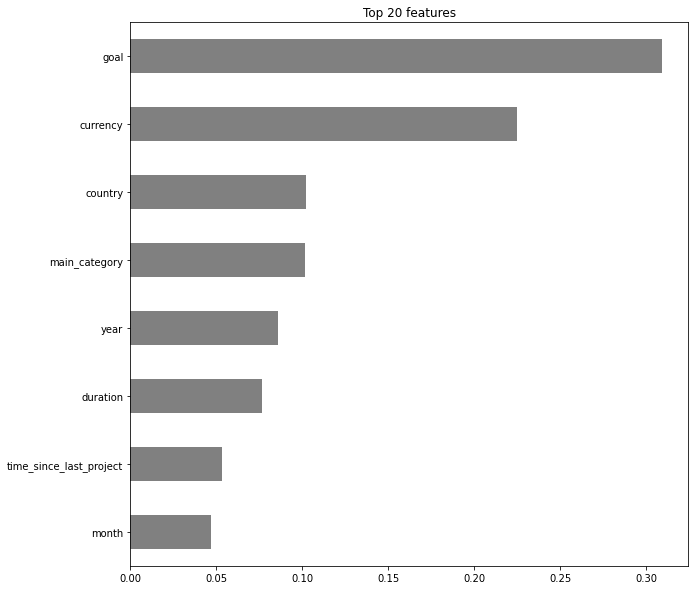

In [48]:
# Get feature importances
#rf = model.named_steps['randomforestclassifier']
importances = pd.Series(model.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [50]:
#giving the prediction values
y_pred = model.predict(X_val)

In [51]:
def matrix(y_true, y_pred):
    data = confusion_matrix(y_true, y_pred)
    index = ['Actual 0', 'Actual 1']
    columns = ['Predicted 0', 'Predicted 1']
    return pd.DataFrame(data, index, columns)
                        
matrix(y_val, y_pred)

,Predicted 0,Predicted 1
Actual 0,40774,6221
Actual 1,9118,9051


In [52]:
model_drop_features = ['goal', 'month', 'year']

model_drop = XGBClassifier(label_encoder = False, random_state=42, n_estimators=50, n_jobs=-1, max_depth=15)
model_drop.fit(X_train[model_drop_features], y_train)

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:37:46] WARNING: ../src/learner.cc:573: 
Parameters: { "label_encoder" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[14:37:46] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              label_encoder=False, learning_rate=0.300000012, max_delta_step=0,
              max_depth=15, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=50, n_jobs=-1,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [53]:
training_accuracy_drop = model_drop.score(X_train[model_drop_features], y_train)
val_accuracy_drop = model_drop.score(X_val[model_drop_features], y_val)
print(training_accuracy_drop, val_accuracy_drop)

0.7648347432429841 0.7396108280645756


In [54]:
#creating and fitting model2 = LogisticRegression

model2 = LogisticRegression(random_state=42, solver='newton-cg')
model2.fit(X_train, y_train)

/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/scipy/optimize/linesearch.py:478: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/home/hj/.local/share/virtualenvs/Kickstarter-aZ_5KkIK/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarni

LogisticRegression(random_state=42, solver='newton-cg')

In [55]:
training_accuracy2 = model2.score(X_train, y_train)
val_accuracy2 = model2.score(X_val, y_val)
print(training_accuracy2, val_accuracy2)

0.7359690011701291 0.7375391320360936


In [56]:
#creating and fitting model3 = DecisionTree

model3 = tree.DecisionTreeClassifier(random_state=42)
model3.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [57]:
training_accuracy3 = model3.score(X_train, y_train)
val_accuracy3 = model3.score(X_val, y_val)
print(training_accuracy3, val_accuracy3)

0.9999923270223092 0.7136916088637898


In [59]:
#creating and fitting model4 = RandomForestClassifer

model4 = RandomForestClassifier(random_state=42, n_estimators=50, n_jobs=-1)
model4.fit(X_train, y_train);

In [60]:
training_accuracy4 = model4.score(X_train, y_train)
val_accuracy4 = model4.score(X_val, y_val)
print(training_accuracy4, val_accuracy4)

0.9997314457808214 0.7547725738137622


In [61]:
#creating and fitting model5 = GradientBoostingClassifer
model5 = GradientBoostingClassifier(random_state=42)
model5.fit(X_train, y_train);

In [62]:

training_accuracy5 = model5.score(X_train, y_train)
val_accuracy5 = model5.score(X_val, y_val)
print(training_accuracy5, val_accuracy5)

0.7665496537568817 0.7667116812964213


In [63]:

#perm_imp is set to be permutation importance of boosting model on X_val and y_val
perm_imp = permutation_importance(model5, X_val, y_val, random_state=42)
#setting data as dict of the permutation importances mean and std.
data = {'imp_mean':perm_imp['importances_mean'],
        'imp_std':perm_imp['importances_std']}
#setting permutation_importances to be data frame with columns in X val to be index and 'data' to be the other columns. Sorting by the mean importance from data.
permutation_importances5 = pd.DataFrame(data,index=X_val.columns).sort_values(by='imp_mean')

permutation_importances5

,imp_mean,imp_std
month,-0.000249,0.000310
currency,0.000282,0.000190
time_since_last_project,0.000623,0.000334
country,0.003137,0.000466
duration,0.014649,0.000480
year,0.014668,0.001005
main_category,0.019812,0.001006
goal,0.057225,0.001047


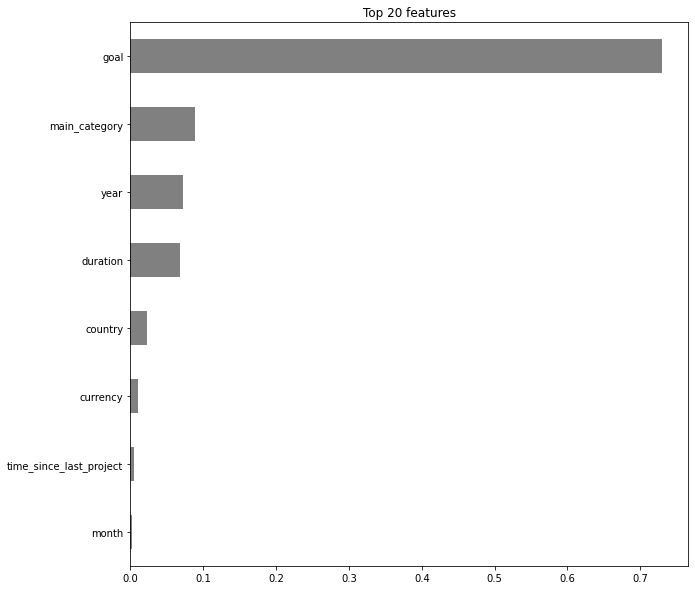

In [64]:
# Get feature importances
importances5 = pd.Series(model5.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances5.sort_values()[-n:].plot.barh(color='grey');

In [66]:
#testing out the model 
model_drop_features = ['main_category', 'goal', 'month', 'year','time_since_last_project']
model_drop = GradientBoostingClassifier(random_state=42, n_estimators=50, max_depth=15)
model_drop.fit(X_train[model_drop_features], y_train)

training_accuracy_drop = model_drop.score(X_train[model_drop_features], y_train)
val_accuracy_drop = model_drop.score(X_val[model_drop_features], y_val)
print(training_accuracy_drop, val_accuracy_drop)

0.8648174790431796 0.7520563501319747


In [68]:
#testing out the model if droppped a few columns
model_drop_features = ['main_category', 'goal', 'month', 'year','time_since_last_project']
model_drop = GradientBoostingClassifier(random_state=42, n_estimators=50, max_depth=15)
model_drop.fit(X_train[model_drop_features], y_train)

training_accuracy_drop = model_drop.score(X_train[model_drop_features], y_train)
val_accuracy_drop = model_drop.score(X_val[model_drop_features], y_val)
print(training_accuracy_drop, val_accuracy_drop)

0.8648174790431796 0.7520563501319747


In [69]:
#testing out the model if droppped a few columns
model_drop_features = ['main_category', 'goal', 'year','time_since_last_project']
model_drop = GradientBoostingClassifier(random_state=42, n_estimators=50, max_depth=15)
model_drop.fit(X_train[model_drop_features], y_train)

training_accuracy_drop = model_drop.score(X_train[model_drop_features], y_train)
val_accuracy_drop = model_drop.score(X_val[model_drop_features], y_val)
print(training_accuracy_drop, val_accuracy_drop)

0.8435288024400069 0.753023141611933


In [71]:
#testing out the model if droppped a few columns
model_drop_features = ['main_category', 'goal', 'year', 'month']
model_drop = GradientBoostingClassifier(random_state=42, n_estimators=50, max_depth=15)
model_drop.fit(X_train[model_drop_features], y_train)

training_accuracy_drop = model_drop.score(X_train[model_drop_features], y_train)
val_accuracy_drop = model_drop.score(X_val[model_drop_features], y_val)
print(training_accuracy_drop, val_accuracy_drop)

0.8122153804837813 0.7561383586029096


In [93]:
#testing out the model if droppped a few columns
model_drop_features = ['duration', 'main_category', 'goal', 'month', 'year','time_since_last_project', 'country', 'currency']
model_drop = GradientBoostingClassifier(random_state=42, n_estimators=50, max_depth=15)
model_drop.fit(X_train, y_train)

training_accuracy_drop = model_drop.score(X_train, y_train)
val_accuracy_drop = model_drop.score(X_val, y_val)
print(training_accuracy_drop, val_accuracy_drop)

0.9075713107364141 0.7642409919587503


In [94]:

import pickle
with open('model.pkl', 'wb') as f:
    pickle.dump(model5, f)

In [95]:
pickle.load(open('model.pkl', 'rb'))

GradientBoostingClassifier(random_state=42)

In [96]:
model5 = pickle.load(open('model.pkl', 'rb'))

In [97]:

model5.predict(X_val.to_numpy())

array([0., 1., 0., ..., 1., 0., 0.])

In [98]:
X_val.to_numpy()

array([[9.00000000e+03, 2.00000000e+00, 2.01500000e+03, ...,
        1.30000000e+01, 1.00000000e+01, 2.79250000e+00],
       [2.00000000e+03, 8.00000000e+00, 2.01300000e+03, ...,
        1.30000000e+01, 1.00000000e+01, 7.61900000e+01],
       [6.00000000e+02, 8.00000000e+00, 2.01400000e+03, ...,
        1.30000000e+01, 1.20000000e+01, 3.12861111e+00],
       ...,
       [2.60000000e+03, 9.00000000e+00, 2.01300000e+03, ...,
        5.00000000e+00, 6.00000000e+00, 6.83055556e+00],
       [1.50000000e+04, 8.00000000e+00, 2.01200000e+03, ...,
        1.30000000e+01, 1.00000000e+01, 3.06833333e+00],
       [1.78370000e+05, 8.00000000e+00, 2.01700000e+03, ...,
        1.30000000e+01, 1.30000000e+01, 6.44425000e+01]])

In [99]:
X_val.shape

(65164, 8)

In [100]:
X_val.head()

,goal,month,year,duration,country,currency,main_category,time_since_last_project
name,,,,,,,,
Starting from scratch,9000.0,2,2015,59,22,13,10,2.792500
Dreams of Elysium,2000.0,8,2013,29,22,13,10,76.190000
The Legends of Christopher Drake: In the Beginning,600.0,8,2014,9,22,13,12,3.128611
World's Best Doctor Who Inspired TARDIS,1000.0,10,2017,29,22,13,5,29.357778
Turbo Pot-Cooking for a Sustainable Life Style,15000.0,12,2015,29,22,13,7,0.920000
